# Overview


In continuous integration (CI) project workflow, developers frequently integrate code into a shared repository. Each integration can then be verified by an automated build and numerous different automated tests. Whenever a failure occurs in a test, developers manually need to analyze failures. Failures in the build can be a legitimate failure or due to some other issues like infrastructure flake, install flake, flaky test, etc. SME can analyze the TestGrid data and determine if failures are legitimate or not. However, it takes a lot of manual effort and reduces the productivity of a team.In this notebook, we will try to detect flaky test. 

## What is flaky test?
A test that passes or fails in a nondeterministic way is known as a flaky test [Refrence](http://mir.cs.illinois.edu/~eloussi2/publications/fse14.pdf). In data science terms, flaky tests pass and fail across multiple runs over a certain period of time. If the test fails consistently over an interval, then it's not an attribute of the flaky test. We will discuss the interval attribute in the later part of this notebook. 


In [70]:
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

# Preparing data

In depth details of this step is given in another [notebook](https://github.com/aicoe-aiops/ocp-ci-analysis/blob/master/notebooks/TestGrid_EDA.ipynb). 

To pull the desired json we can follow this syntax:

https://testgrid.k8s.io/{dashboard_name}/table?&show-stale-tests=&tab={job_name}

From the work above we know how to get the list of all the dashboards and associated jobs. Here we will get the data for the job "release-openshift-ocp-e2e-aws-scaleup-rhel7-4.3" as an example.

In [71]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-ocp-release-4.3-informing/table?&show-stale-tests"
    "=&tab=release-openshift-ocp-e2e-aws-scaleup-rhel7-4.3"
)

In [72]:
details = pd.DataFrame(response.json()["tests"]).drop(
    ["linked_bugs", "messages", "user_property", "target", "original-name"],
    axis=1,
)
details.head(10)

,name,alert,short_texts,statuses
0,openshift-tests.Monitor cluster while tests ex...,"{'fail-cl': '097314e0e', 'fail-count': 71, 'fa...","[F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, ...","[{'count': 2, 'value': 12}, {'count': 2, 'valu..."
1,Overall,None,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[{'count': 1, 'value': 12}, {'count': 1, 'valu..."
2,openshift-tests.[sig-network] DNS should provi...,None,"[F, , , , , , , , , , , , , , , , , , , , , , ...","[{'count': 1, 'value': 12}, {'count': 1, 'valu..."
3,openshift-tests.[sig-storage] In-tree Volumes ...,None,"[F, , , , , , F, , , , , , , , , , , , , F, , ...","[{'count': 1, 'value': 12}, {'count': 1, 'valu..."
4,openshift-tests.[sig-storage] In-tree Volumes ...,None,[F],"[{'count': 1, 'value': 12}, {'count': 86, 'val..."
5,openshift-tests.[sig-storage] Zone Support Ver...,None,[F],"[{'count': 1, 'value': 12}, {'count': 86, 'val..."
6,operator.Run template e2e-aws-scaleup-rhel7 - ...,None,"[F, , F, , , , , F, , , , , , , , , , , , , , ...","[{'count': 1, 'value': 12}, {'count': 1, 'valu..."
7,operator.Run template e2e-aws-scaleup-rhel7 - ...,None,"[, , F, , , , , , , , , , , , , , , , , , , , ...","[{'count': 2, 'value': 1}, {'count': 1, 'value..."
8,openshift-tests.[sig-scheduling] Multi-AZ Clus...,None,"[, , , , , F, F, , , , , , , , , , , , , , , ,...","[{'count': 2, 'value': 1}, {'count': 1, 'value..."
9,openshift-tests.[sig-apps] StatefulSet [k8s.io...,None,"[, , , , , F, , , , , , , , , , , , , , , , , ...","[{'count': 2, 'value': 1}, {'count': 1, 'value..."


From the column "statuses" above we can see that the time series data is run length encoded. Let's add a decoded column so we can get the data in an array format we could use for machine learning.

In [73]:
def decode_run_length(x):
    lst = []
    for run_length in x:
        extension = [run_length["value"]] * run_length["count"]
        lst.extend(extension)
    return lst


details["values"] = details["statuses"].apply(decode_run_length)

Column "short_texts" is the existing labels of the flaky test. There are some missing entries for this column corresponding to 'not_run' test cases. Let's add that. 

In [74]:
def label_arr(val_array, text_array):
    iter_text = iter(text_array)
    output_arr = []
    for i in val_array:
        if i == 0:
            output_arr.append("")
        else:
            output_arr.append(next(iter_text))
    return output_arr


details["label_arr"] = details.apply(
    lambda x: label_arr(x["values"], x["short_texts"]), axis=1
)

TestGrids are made of a set of tests that either pass or failing over time, essentially they are multidimensional time series where the values can take either 0 (not run), 1 (pass) or 12 (fail). 

Now that we have all our data unrolled, lets plot it. We will use green color for pass (1), red color for fail (12), and white color for not run (0). We plotted just the first 40 rows to save space.

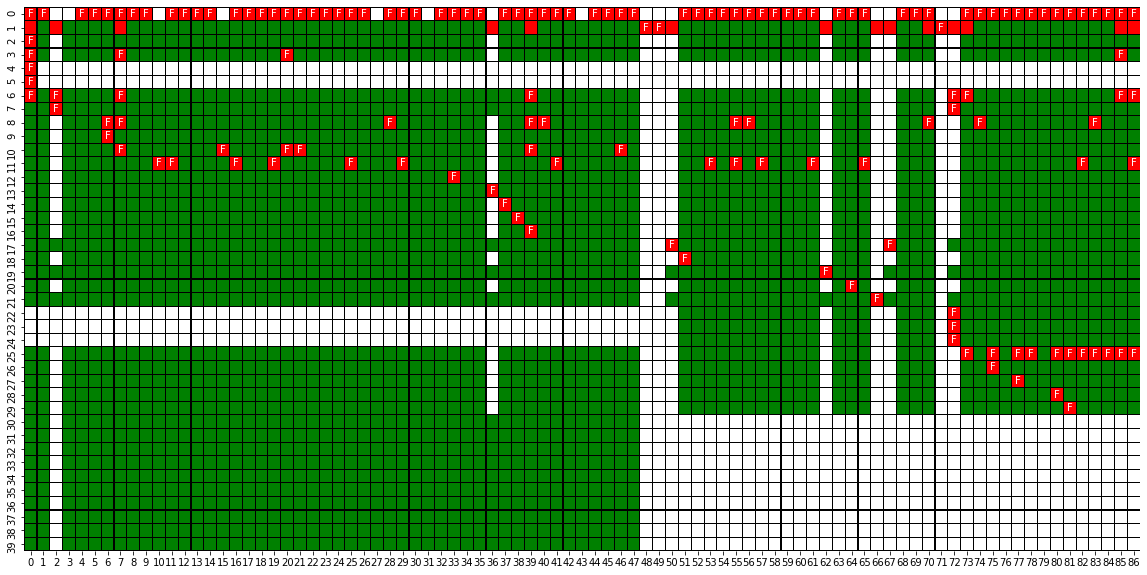

In [75]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12], ncolors=2)
sns.heatmap(
    np.array(list(details["values"][:40].values)),
    annot=np.array(list(details["label_arr"][:40].values)),
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.show()

Cells with F annotations in the above graph are the existing labels given by the testgrid algorithm. 

# Flakey test detection

In the following section, we will explore different methods to detect flaky test. 

## Naive flakiness method

This method calculates flakiness as a ratio of failed tests to total tests. Flaky test passes and fails on several successive revisions, but this method cannot catch this signal of the flaky test. 

In [8]:
def naive_flake_calc(test_row):
    return 100 * (np.array(test_row) == 12).sum() / len(test_row)

Now, we will calculate the flakiness score by naive method for each test in our dataset.

In [76]:
details["naive_flakiness_score"] = details["values"].apply(
    lambda x: naive_flake_calc(x)
)
details["naive_flakiness_score"]

0       81.609195
1       19.540230
2        1.149425
3        4.597701
4        1.149425
          ...    
1004     0.000000
1005     0.000000
1006     0.000000
1007     0.000000
1008     0.000000
Name: naive_flakiness_score, Length: 1009, dtype: float64

In the following cell, we have shown a drawback of the naive flakiness method. As we can see in the below cell, we have `test_array` consist of consecutive test failures over a certain period type, which is not an attribute of a flaky test still. However, we got a high flakiness score. 

In [10]:
test_array = [
    1,
    1,
    1,
    1,
    1,
    1,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
naive_flake_calc(test_array)

45.833333333333336

##  Flip flakiness method

As we discussed earlier, flaky test pass and fail across multiple runs over a certain period of time. We trigger this behavior of a flaky test by using the concept of edge. Edge is the transition of a particular test case from pass to fail. Let's dig this behavior into more detail using the following example.

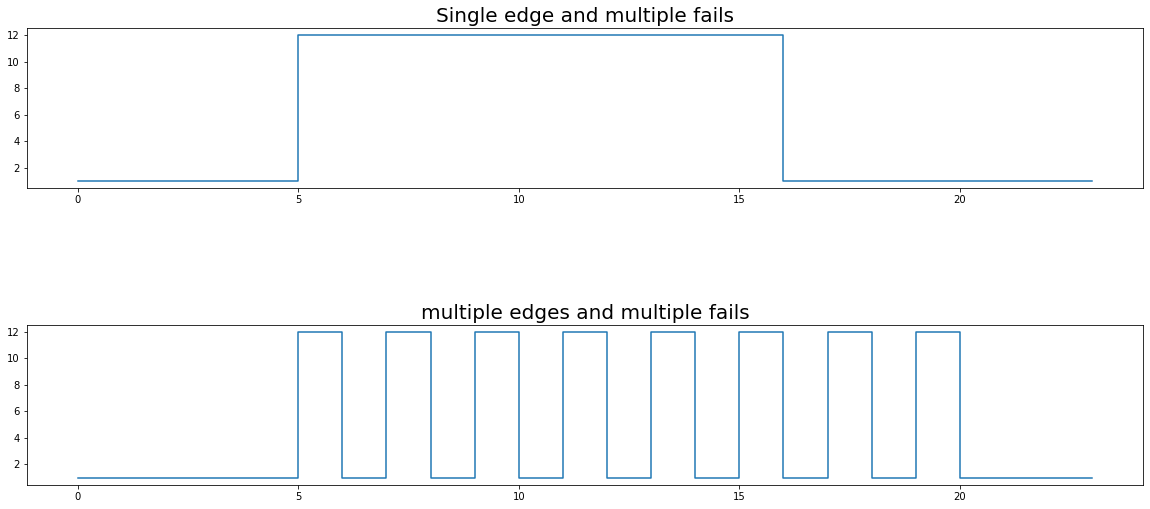

In [11]:
plt.figure(
    figsize=(20, 10)
)  # instantiating figure to be 5"x5", 100 dpi resolution


test_array = [
    1,
    1,
    1,
    1,
    1,
    1,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
x = np.arange(len(test_array))
plt.subplot(2, 1, 1, aspect=0.3)
plt.step(x, test_array)
plt.title("Single edge and multiple fails", fontsize=20)

plt.subplot(2, 1, 2, aspect=0.3)
test_array_1 = [
    1,
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
]
plt.step(x, test_array_1)
plt.title("multiple edges and multiple fails", fontsize=20)


plt.show()

In the images above, we have shown test case results for 25 runs. In the first image, we can see there are multiple fails but only a single edge. In the second image, we have fewer fails compared to first images but multiple edges. Therefore, the second test exhibits a more irregular behavior pattern with many more edges. Therefore, we can conclude that test case 2 is more likely to be a flaky test, whereas test case 1 seems not to be.

We calculated the flakiness score as the number of edges divided by total runs. The most common approach to detect flaky test is to run flaky test multiple times and if it's passes in any run then it is not considerd flaky test [Refrence](http://mir.cs.illinois.edu/~eloussi2/publications/fse14.pdf). At google, If the test is failing three times in a row, then only it reported as real failures; otherwise, it's considered a flaky test [Refrence](https://testing.googleblog.com/2016/05/flaky-tests-at-google-and-how-we.html). Hence, we ignored more than three consecutive failures and test cases that are not run while calculating the flakiness score.

Flakiness score lies between 0 and 100; 0 is no flakiness, and 100 is maximum flakiness. 

In [77]:
def calc_consecutive_failures(test_row, i):
    """This function calculates number of consecutive failures

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12 values as not run, pass, fail respectively
    i : float, int
            index in array i

    Returns
    ----------
    result: int
            number of consecutive failures from index i
    """

    result = 0
    while i < len(test_row) and (test_row[i] == 12 or test_row[i] == 0):
        if test_row[i] == 12:
            result += 1
        i += 1
    return result


def calc_flakiness_score(test_row, ignore_failures_in_a_row=3):
    """This function calculate flakiness score as the number of edges divided by total runs.
    At google, If the test is failing three times in a row, then only it reported as real failures;
    otherwise, it's considered a flaky test.
    (https://testing.googleblog.com/2016/05/flaky-tests-at-google-and-how-we.html)
    Hence, we ignored three or more than three consecutive failures
    and test cases that are not run while calculating the flakiness score.

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12 values as not run, pass, fail respectively

    Returns
    ----------
    flakiness: int
            Flakiness score lies between 0 and 100; 0 is no flakiness, and 100 is maximum flakiness.
    """
    flips = 0
    i = 0
    ## ignore not run instances in the starting
    while i < len(test_row) and test_row[i] == 0:
        i += 1

    ## intializing last_passing variable value
    if i >= len(test_row):
        return 0
    elif test_row[i] == 1:
        last_passing = True
    elif test_row[i] == 12:
        last_passing = False
    considerd = 1
    i += 1

    while i < len(test_row):
        ## ignoring more than three consecutive failures
        ## If the test is consecutively failing for three or more than three runs,
        ## we considered did not consider it an edge.
        cf = calc_consecutive_failures(test_row, i)
        if cf >= ignore_failures_in_a_row:
            i = i + cf
            if i >= len(test_row):
                break

        s = test_row[i]
        if s == 1:
            ## run is pass
            considerd += 1
            last_passing = True
        elif s == 0:
            ## not run
            pass
        elif s == 12:
            ## run is fail
            considerd += 1
            if last_passing:
                flips += 1
            last_passing = False
        i += 1
    if considerd == 0:
        return 0
    ## multiplying by 2 since flakiness score lies between 0 and 100
    flakiness = 2 * (flips / (considerd)) * 100
    return flakiness

Below, we have tested our function using some basic test cases.

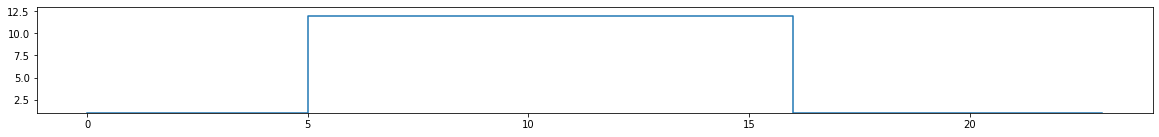

flakiness score of above test run using flip-flakiness method is:  0.0


In [14]:
plt.figure(figsize=(20, 10))
test_array = [
    1,
    1,
    1,
    1,
    1,
    1,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
x = np.arange(len(test_array))
plt.step(x, test_array)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array),
)

In the above figure, we can see there is only one edge with more than three consecutive failures. Hence we did not consider the above test as a flaky test. Hence, the total flakiness score using the `flip flakiness` method is 0

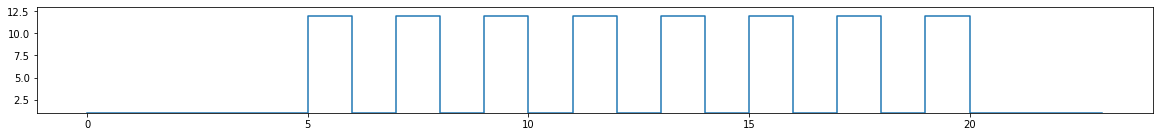

flakiness score of above test run using flip-flakiness method is:  66.66666666666666


In [15]:
plt.figure(figsize=(20, 10))
test_array_1 = [
    1,
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
]
x = np.arange(len(test_array_1))
plt.step(x, test_array_1)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_1),
)

In the above figure, we can see there are multiples edges. Hence, this test exhibits a more irregular behavior pattern. Therefore, our flakiness score is on the higher side. 

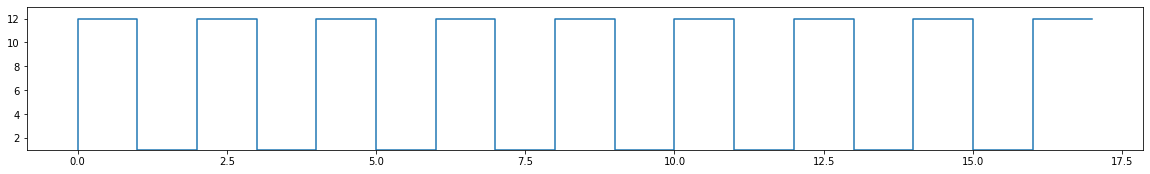

flakiness score of above test run using flip-flakiness method is:  100.0


In [16]:
plt.figure(figsize=(20, 10))
test_array_7 = [1, 12, 1, 12, 1, 12, 1, 12, 1, 12, 1, 12, 1, 12, 1, 12, 1, 12]
x = np.arange(len(test_array_7))
plt.step(x, test_array_7)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_7),
)

In the above figure, we have shown the extreme flaky test with irregular behavior patterns. Therefore, our flakiness score is perfect 100.

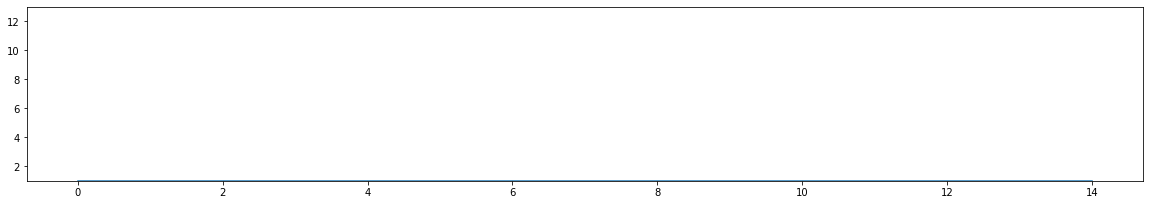

flakiness score of above test run using flip-flakiness method is: 0.0


In [17]:
plt.figure(figsize=(20, 10))
test_array_2 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
x = np.arange(len(test_array_2))
plt.step(x, test_array_2)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

print(
    "flakiness score of above test run using flip-flakiness method is:",
    calc_flakiness_score(test_array_2),
)

In the above figure, we can see all the test runs passed. Hence, our flakiness score is 0

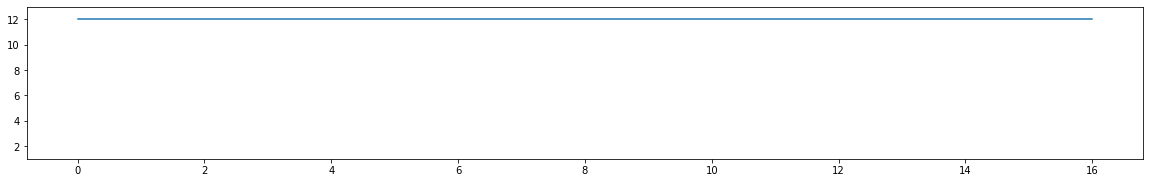

flakiness score of above test run using flip-flakiness method is:  0.0


In [18]:
plt.figure(figsize=(20, 10))
test_array_3 = [
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
]
x = np.arange(len(test_array_3))
plt.step(x, test_array_3)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_3),
)

In the above figure, we can see there is no edge in this test run, and there are consistent failures occurring for all the runs. Hence we did not consider the above test as a flaky test. Hence, the total flakiness score using the `flip flakiness` method is 0

In [19]:
test_array_4 = [
    12,
    0,
    12,
    0,
    12,
    12,
    12,
    12,
    12,
    0,
    0,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
]
calc_flakiness_score(test_array_4)

0.0

Above, we can see we ignore not run instants in our calculation of flakiness score. <br>
Below, we are included test cases from testgrid repos. [Refrence](https://github.com/GoogleCloudPlatform/testgrid/blob/2a016ff75a27fff1550f5e9f5319cf0114182547/pkg/summarizer/analyzers/flipanalyzer_test.go)

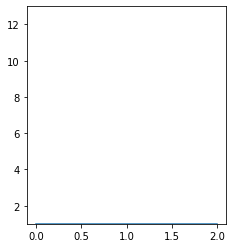

flakiness score of above test run using flip-flakiness method is:  0.0


In [60]:
test_array_google_1 = [1, 1, 1]
x = np.arange(len(test_array_google_1))
plt.step(x, test_array_google_1)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()
print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_google_1),
)

In the above test, we can see all the test runs passed. Hence, our flakiness score is 0

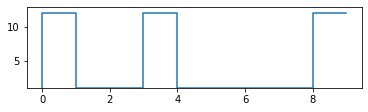

flakiness score of above test run using flip-flakiness method is:  60.0


In [61]:
test_array_google_2 = [1, 12, 1, 1, 12, 1, 1, 1, 1, 12]
x = np.arange(len(test_array_google_2))
plt.step(x, test_array_google_2)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()
print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_google_2),
)

In the above figure, we can see there are multiples edges. Hence, this test exhibits a more irregular behavior pattern. Therefore, our flakiness score is on the higher side. 

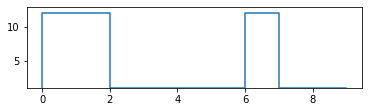

flakiness score of above test run using flip-flakiness method is:  40.0


In [62]:
test_array_google_3 = [1, 12, 12, 1, 1, 1, 1, 12, 1, 1]
x = np.arange(len(test_array_google_3))
plt.step(x, test_array_google_3)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()
print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_google_3),
)

In the above figure, we can see there are multiples edges. Hence, this test exhibits a more irregular behavior pattern. Therefore, our flakiness score is on the higher side. 

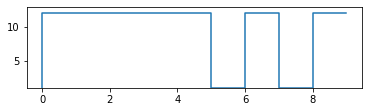

flakiness score of above test run using flip-flakiness method is:  80.0


In [63]:
test_array_google_4 = [1, 12, 12, 12, 12, 12, 1, 12, 1, 12]
x = np.arange(len(test_array_google_4))
plt.step(x, test_array_google_4)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()
print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_google_4),
)

In the above figure, we can see there are multiples edges. Hence, this test exhibits a more irregular behavior pattern. Therefore, our flakiness score is on the higher side. Note that there is a continuous failure from the test run 2 to 5. Hence, we didnt consider it as an edge.

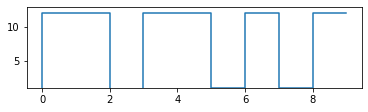

flakiness score of above test run using flip-flakiness method is:  100.0


In [64]:
test_array_google_5 = [1, 12, 12, 0, 12, 12, 1, 12, 1, 12]
x = np.arange(len(test_array_google_5))
plt.step(x, test_array_google_5)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()
print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_google_5),
)

In the above figure, we have shown the extreme flaky test with irregular behavior patterns. Therefore, our flakiness score is perfect 100. Note that there is a continuous failure from the test run 2 to 6 (Also, we are ignoring 0 test run). Hence, we didnt consider it as an edge.

Now, we will calculate the flakiness score by flip method for each test in our dataset.

In [78]:
details["flip_flakiness_score"] = details["values"].apply(
    lambda x: calc_flakiness_score(x)
)
details["flip_flakiness_score"]

0        0.000000
1       17.500000
2        0.000000
3        7.792208
4        0.000000
          ...    
1004     0.000000
1005     0.000000
1006     0.000000
1007     0.000000
1008     0.000000
Name: flip_flakiness_score, Length: 1009, dtype: float64

## Flip Flakiness with Optimal Distance

One of the downsides of finding a single value for each test case is that there might be two different consecutive time periods for which the test case is behaving flaky. Or the number of edges is relatively low compares to total runes; hence your flakiness score is really low, but the test is still flaky. Let's illustrate this statement by the example. 

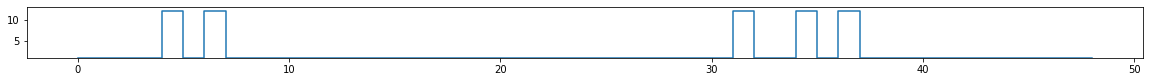

flakiness score of above test run using flip-flakiness method is:  20.408163265306122


In [32]:
plt.figure(figsize=(20, 10))
test_array_5 = [
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
x = np.arange(len(test_array_5))
plt.step(x, test_array_5)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_5),
)

As we can see in the above image, we have two separate time periods for which behavior is flaky. We can see that the behavior of the test is flaky between runs [4,7] and [31,37]. However, our flakiness score is low since the total number of runs is higher. 

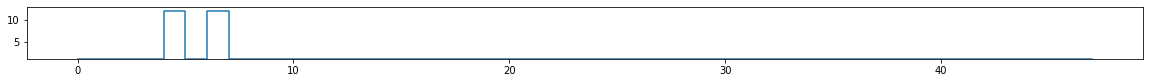

flakiness score of above test run using flip-flakiness method is:  8.333333333333332


In [33]:
plt.figure(figsize=(20, 10))
test_array_6 = [
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
x = np.arange(len(test_array_6))
plt.step(x, test_array_6)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_6),
)

Similarly, in the above image, we can see that the behavior of the test is flaky between runs [4,7]. However, our flakiness score is low since the number of the total number of runs is higher. 

To overcome this downside, instead of calculating the flakiness score on the entire run. We just decided to calculate the flakiness score between edges since it will maximize our flakiness score. More specifically, we calculated the flakiness score between the two farthest edges, which have a flakiness score greater than a certain threshold.  Currently, we are using the threshold as flakiness score 30, but we can change it according to need of the application. 

In [79]:
def calc_optimal_flakiness_score(test_array, thersold=30):
    """calculate the flakiness score between edges since it will maximize our flakiness score.
    More specifically, we calculated the flakiness score between the two farthest edges,
    which have a flakiness score greater than a certain threshold.

    Parameters
    ----------
    test_row : array
            array of test runs with 0, 1, 12 values as not run, pass, fail respectively
    thersold: int default 30

    Returns
    ----------
    modified_test_array: numpy array
                        modified test grid where the value of failure due to flake is 6
    flake_edges_dict: dictionary
            key of the dictionary is a tuple of time period, and value is the flakiness score between the time period
    """
    modified_test_array = test_array.copy()
    flake_edges = []  ## array to store edges
    label_array = [""] * len(test_array)  ## array to stores labels
    flake_edges_dict = {}
    ignore_failures_in_a_row = 3
    i = 0
    while i < len(test_array) and test_array[i] == 0:
        i += 1

    ## intializing last_passing variable value
    if i >= len(test_array):
        return modified_test_array, flake_edges_dict
    elif test_array[i] == 1:
        last_passing = True
    elif test_array[i] == 12:
        last_passing = False
    i += 1

    ## Finding all the edges in our test runs
    while i < len(test_array):
        ## ignoring more than three consecutive failures
        ## If the test is consecutively failing for three or more than three runs,
        ## we considered did not consider it an edge.
        cf = calc_consecutive_failures(test_array, i)
        if cf >= ignore_failures_in_a_row:
            i = i + cf
            if i >= len(test_array):
                break
        s = test_array[i]
        if s == 1:
            last_passing = True
        elif s == 0:
            pass
        else:
            if last_passing:
                flake_edges.append(i - 1)
            last_passing = False
        i = i + 1

    ## flakiness score between the two farthest edges, which have a flakiness score greater than a certain threshold.
    p = 0
    while p < len(flake_edges) - 1:
        possible_flake = False
        for q in range(p + 1, len(flake_edges)):
            curr_flake = calc_flakiness_score(
                test_array[flake_edges[p] : flake_edges[q] + 2]
            )
            if curr_flake > thersold:
                possible_flake = True
                max_flake = curr_flake
                max_p = flake_edges[p]
                max_q = flake_edges[q]
            else:
                break
        if possible_flake:
            for k in range(max_p, max_q + 2):
                if modified_test_array[k] == 12:
                    modified_test_array[k] = 6
                    label_array[k] = "F"
                    if k + 1 < len(modified_test_array):
                        if modified_test_array[k + 1] == 12:
                            modified_test_array[k + 1] = 6
                            label_array[k + 1] = "F"

            arr = []
            arr.append(max_p)
            arr.append(max_q + 1)
            flake_edges_dict[tuple(arr)] = max_flake

        p = q
    return modified_test_array, flake_edges_dict, label_array

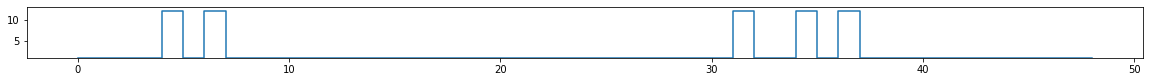

flakiness score dictionary using Flip Flakiness with Optimal Distance method is:  {(4, 7): 100.0, (31, 37): 85.71428571428571}


In [35]:
plt.figure(figsize=(20, 10))
test_array_5 = [
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
x = np.arange(len(test_array_5))
plt.step(x, test_array_5)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

(
    modified_test_array,
    flake_dict,
    modified_label_array,
) = calc_optimal_flakiness_score(test_array_5)
print(
    "flakiness score dictionary using Flip Flakiness with Optimal Distance method is: ",
    flake_dict,
)

As we can see in the above image, we have two separate time periods for which behavior is flaky. We can see that the behavior of the test is flaky between runs [4,7] and [31,37]. Using `flip flakiness with optimal distance` methods we can see above, we have a flakiness score of 100 between test run 4 to 7 and a flakiness score of 85.71 between test run 31 to 37.

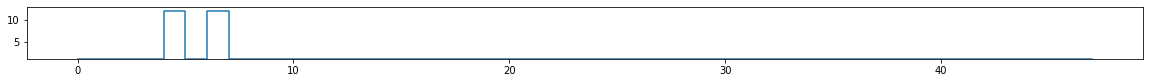

flakiness score dictionary using Flip Flakiness with Optimal Distance method is:  {(4, 7): 100.0}


In [37]:
plt.figure(figsize=(20, 10))
test_array_6 = [
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
x = np.arange(len(test_array_6))
plt.step(x, test_array_6)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

(
    modified_test_array,
    flake_dict,
    modified_label_array,
) = calc_optimal_flakiness_score(test_array_6)
print(
    "flakiness score dictionary using Flip Flakiness with Optimal Distance method is: ",
    flake_dict,
)

As we can see above, we have a flakiness score of 100 between test run 4 to 7.

# Comparision of different methods

## Comparison of custom test cases
Below we are comparing custom test runs.

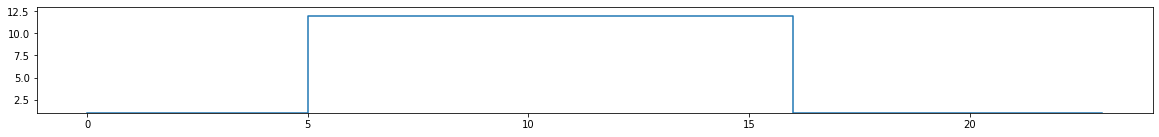

flakiness score of above test run using naive method is:  45.833333333333336
flakiness score of above test run using flip-flakiness method is:  0.0
flakiness score dictionary using Flip Flakiness with Optimal Distance method is:  {}


In [65]:
plt.figure(figsize=(20, 10))
test_array = [
    1,
    1,
    1,
    1,
    1,
    1,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
x = np.arange(len(test_array))
plt.step(x, test_array)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

(
    modified_test_array,
    flake_dict,
    modified_label_array,
) = calc_optimal_flakiness_score(test_array)
print(
    "flakiness score of above test run using naive method is: ",
    naive_flake_calc(test_array),
)
print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array),
)
print(
    "flakiness score dictionary using Flip Flakiness with Optimal Distance method is: ",
    flake_dict,
)

In the above figure, we got a flakiness score of 45.83 using the `naive flakiness` method. <br>
However, we can see there is only one edge with more than three consecutive failures. Hence we did not consider the above test as a flaky test and considered it as a legitimate failure. Hence, the total flakiness score using the `flip flakiness` method is 0. Also, the flakiness score `flip flakiness with optimal distance` method is giving an empty dictionary i.e. there is no flakiness or flakiness score is 0.

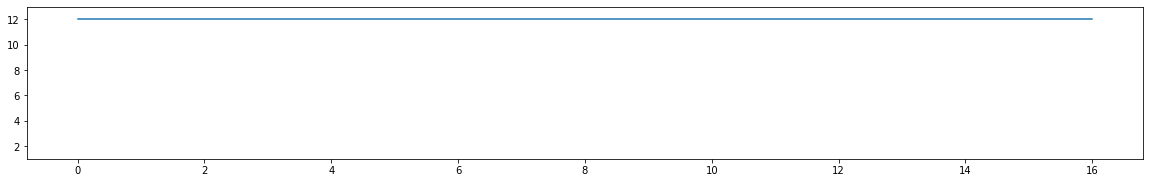

flakiness score of above test run using naive method is:  100.0
flakiness score of above test run using flip-flakiness method is:  0.0
flakiness score dictionary using Flip Flakiness with Optimal Distance method is:  {}


In [66]:
plt.figure(figsize=(20, 10))
test_array_3 = [
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
    12,
]
x = np.arange(len(test_array_3))
plt.step(x, test_array_3)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

(
    modified_test_array,
    flake_dict,
    modified_label_array,
) = calc_optimal_flakiness_score(test_array_3)
print(
    "flakiness score of above test run using naive method is: ",
    naive_flake_calc(test_array_3),
)
print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_3),
)
print(
    "flakiness score dictionary using Flip Flakiness with Optimal Distance method is: ",
    flake_dict,
)

In the above figure, we got a flakiness score of 100 using the `naive flakiness` method. <br>
However, we can see there is no edge in this test run, and there are consistent failures occurring for all the runs. Hence we did not consider the above test as a flaky test and considered it as a legitimate failure. Hence, the total flakiness score using the `flip flakiness` method is 0. Also, the flakiness score `flip flakiness with optimal distance` method is giving an empty dictionary i.e. there is no flakiness or flakiness score is 0.

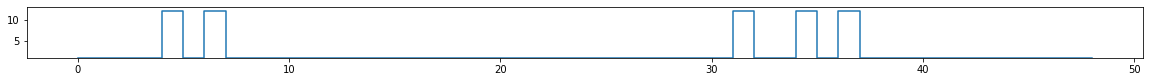

flakiness score of above test run using naive method is:  10.204081632653061
flakiness score of above test run using flip-flakiness method is:  20.408163265306122
flakiness score dictionary using Flip Flakiness with Optimal Distance method is:  {(4, 7): 100.0, (31, 37): 85.71428571428571}


In [67]:
plt.figure(figsize=(20, 10))
test_array_5 = [
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
x = np.arange(len(test_array_5))
plt.step(x, test_array_5)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

(
    modified_test_array,
    flake_dict,
    modified_label_array,
) = calc_optimal_flakiness_score(test_array_5)
print(
    "flakiness score of above test run using naive method is: ",
    naive_flake_calc(test_array_5),
)
print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_5),
)
print(
    "flakiness score dictionary using Flip Flakiness with Optimal Distance method is: ",
    flake_dict,
)

As we can see in the above image, we have two separate time periods for which behavior is flaky. We can see that the behavior of the test is flaky between runs [4,7] and [31,37]. However, our flakiness score using `flip-flakiness` and `naive flakiness` method is low since the number of the total number of runs is higher. <br>

Using `flip flakiness with optimal distance` methods we can see above, we have a flakiness score of 100 between test run 4 to 7 and a flakiness score of 85.71 between test run 31 to 37. Hence, we can conclude we are getting the best results with `flip flakiness with optimal distance` method for this particular test case.

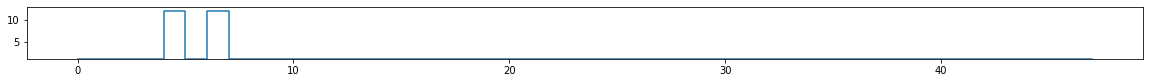

flakiness score of above test run using naive method is:  4.166666666666667
flakiness score of above test run using flip-flakiness method is:  8.333333333333332
flakiness score dictionary using Flip Flakiness with Optimal Distance method is:  {(4, 7): 100.0}


In [68]:
plt.figure(figsize=(20, 10))
test_array_6 = [
    1,
    1,
    1,
    1,
    1,
    12,
    1,
    12,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
x = np.arange(len(test_array_6))
plt.step(x, test_array_6)
plt.ylim(1, 13)
plt.axes().set_aspect(0.2)
plt.show()

(
    modified_test_array,
    flake_dict,
    modified_label_array,
) = calc_optimal_flakiness_score(test_array_6)
print(
    "flakiness score of above test run using naive method is: ",
    naive_flake_calc(test_array_6),
)
print(
    "flakiness score of above test run using flip-flakiness method is: ",
    calc_flakiness_score(test_array_6),
)
print(
    "flakiness score dictionary using Flip Flakiness with Optimal Distance method is: ",
    flake_dict,
)

As we can see above, in the above test case, we can see that the behavior of the test is flaky between runs [4,7]. However, our flakiness score using `flip-flakiness` and and `naive flakiness` method is low since the number of the total number of runs is higher. 

Using `flip flakiness with optimal distance` methods we can see above, we have a flakiness score of 100 between test run 4 to 7. Hence, we can conclude we are getting the best results with `flip flakiness with optimal distance` method for this particular test case.

## Comparison of testgrids
Below we are comparing custom testgirds with annotations.

### Original testgrid

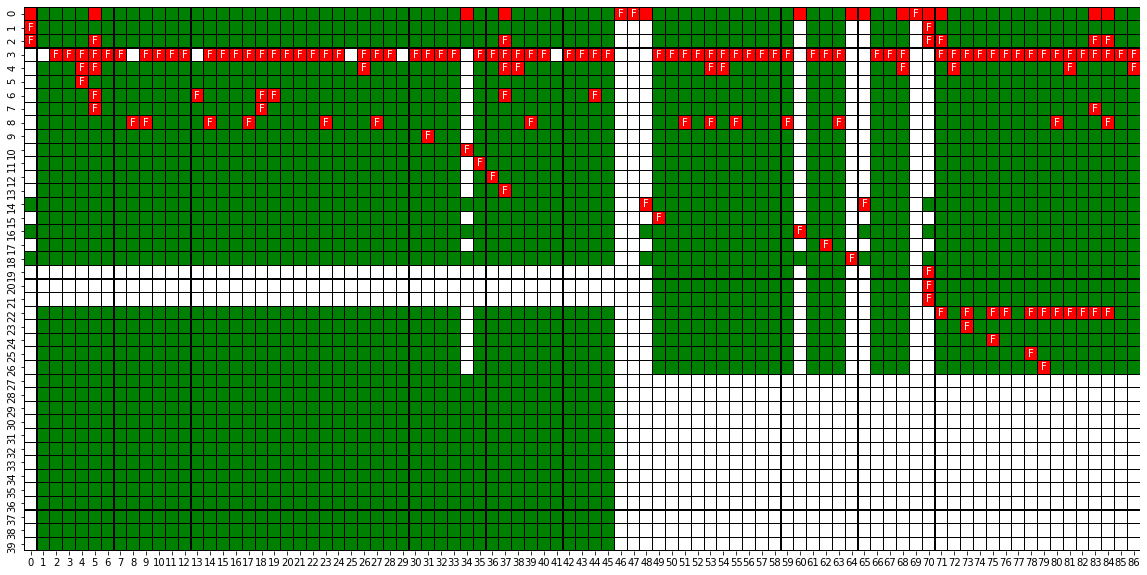

In [43]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12], ncolors=2)
sns.heatmap(
    np.array(list(details["values"][:40].values)),
    annot=np.array(list(details["label_arr"][:40].values)),
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.show()

Cells with F annotations in the above graph are the existing labels given by the testgrid algorithm. 

In [93]:
total_existing_flake_label = np.count_nonzero(
    np.array(list(details["label_arr"][:40].values)) == "F"
)
print(
    "total number of existing flake label given by the testgrid algorithm is",
    total_existing_flake_label,
)

total number of existing flake label given by the testgrid algorithm is 151


### Naive flake method testgrid
Below we are annotating testgrid using the naive flake detection method.

In [94]:
def navie_flake_annotation(val_array):
    label_arr = [""] * len(val_array)
    for i in range(len(val_array)):
        if val_array[i] == 12:
            label_arr[i] = "F"
    return label_arr


flake_score_thersold = 15
total_len = len(details["values"].iloc[0])
details["naive_label_array"] = [[""] * total_len] * len(details)
flake_df = details[details["naive_flakiness_score"] > flake_score_thersold]
flake_df["naive_label_array"] = flake_df["values"].apply(
    lambda x: navie_flake_annotation(x)
)
details = details.mask(
    details["naive_flakiness_score"] > flake_score_thersold, flake_df
)

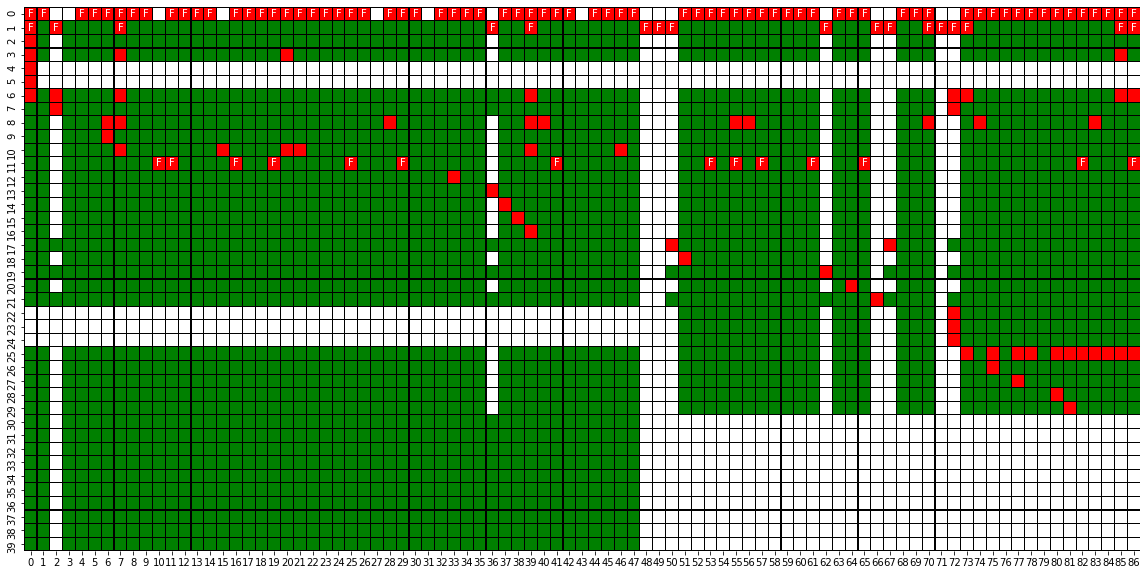

In [95]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12], ncolors=2)
sns.heatmap(
    np.array(list(details["values"][:40].values)),
    annot=np.array(list(details["naive_label_array"][:40].values)),
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.show()

In [97]:
np.count_nonzero(
    np.array(list(details["naive_label_array"][:40].values)) == "F"
)

102

Cells with F annotations in the above graph are the labels given by the naive flake algorithm. 

In [104]:
total_naive_flake_label = np.count_nonzero(
    np.array(list(details["naive_label_array"].values)) == "F"
)
print(
    "total number of flake label given by the `naive flakiness method` is",
    total_naive_flake_label,
)
print(
    "the total flaky test detected by the `naive flakiness method` is",
    round(total_naive_flake_label / total_existing_flake_label, 2),
    "times than the total flaky test detected by the existing testgrid method ",
)

total number of flake label given by the `naive flakiness method` is 102
the total flaky test detected by the `naive flakiness method` is 0.68 times than the total flaky test detected by the existing testgrid method 


### Flip flake method testgrid
Below we are annotating testgrid using the flip flake detection method.

In [100]:
def flip_flake_annotation(val_array, ignore_failures_in_a_row=3):
    label_arr = [""] * len(val_array)
    i = 0
    while i < len(val_array):
        cf = calc_consecutive_failures(val_array, i)
        if cf >= ignore_failures_in_a_row:
            i = i + cf
            if i >= len(val_array):
                break
        if val_array[i] == 12:
            label_arr[i] = "F"
        i = i + 1
    return label_arr


total_len = len(details["values"].iloc[0])
details["flip_flake_label_array"] = [[""] * total_len] * len(details)
flake_df = details[details["flip_flakiness_score"] > 15]
flake_df["flip_flake_label_array"] = flake_df["values"].apply(
    lambda x: flip_flake_annotation(x)
)
details = details.mask(details["flip_flakiness_score"] > 15, flake_df)

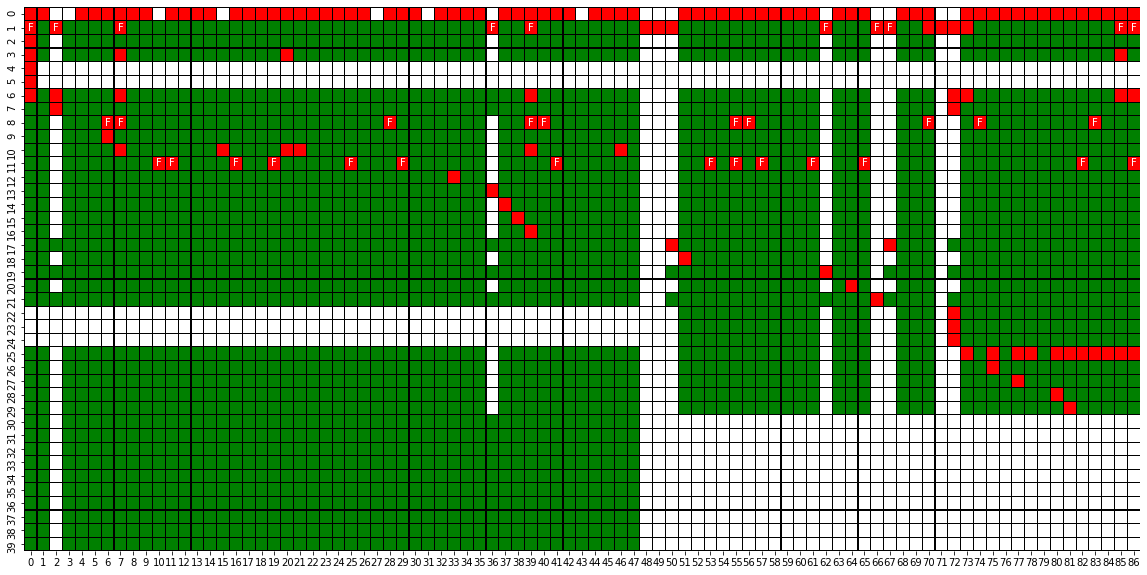

In [101]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12], ncolors=2)
sns.heatmap(
    np.array(list(details["values"][:40].values)),
    annot=np.array(list(details["flip_flake_label_array"][:40].values)),
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.show()

Cells with F annotations in the above graph are the labels given by the flip flake algorithm. 

In [109]:
total_flip_flake_label = np.count_nonzero(
    np.array(list(details["flip_flake_label_array"].values)) == "F"
)
print(
    "total number of flake label given by the `flip flakiness` method is",
    total_flip_flake_label,
)
print(
    "the total flaky test detected by the `flip flake` method is",
    round(total_flip_flake_label / total_existing_flake_label, 2),
    "times than the total flaky test detected by the existing testgrid method ",
)

total number of flake label given by the `flip flakiness` method is 34
the total flaky test detected by the `flip flake` method is 0.23 times than the total flaky test detected by the existing testgrid method 


### Flip flakiness with optimal distance method testgrid
Below we are annotating testgrid using the Flip flakiness with optimal distance method

In [107]:
modified_labled_array = details["values"].apply(
    lambda x: calc_optimal_flakiness_score(x, 20)[2]
)

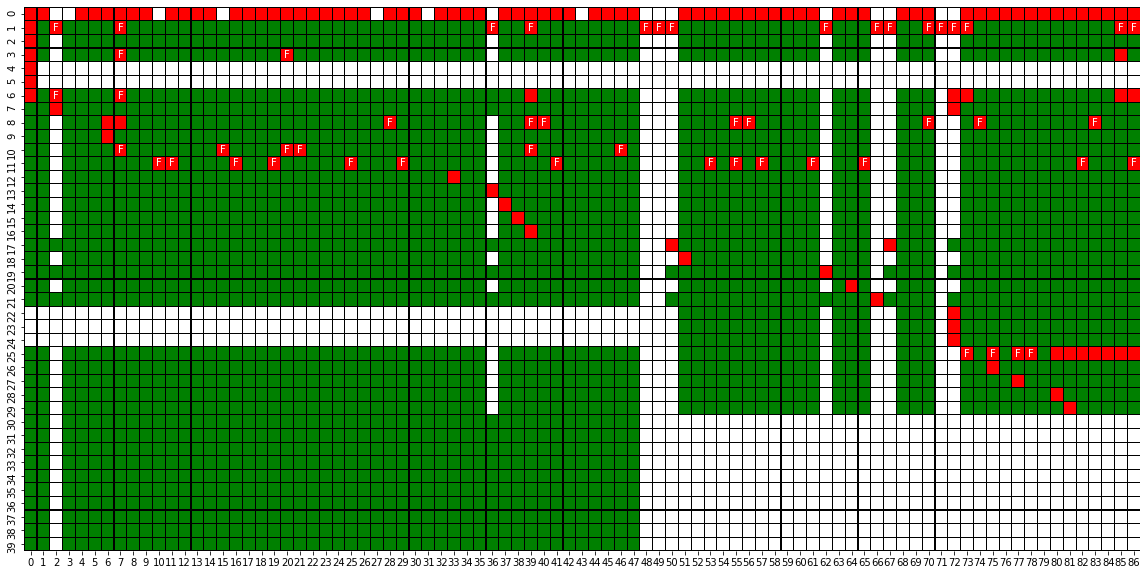

In [108]:
plt.figure(figsize=(20, 10))
cmap = colors.ListedColormap(["white", "green", "red"])
norm = colors.BoundaryNorm(boundaries=[0, 1, 12], ncolors=2)
sns.heatmap(
    np.array(list(details["values"][:40].values)),
    annot=np.array(list(modified_labled_array[:40].values)),
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar=False,
    linewidths=0.1,
    linecolor="Black",
)
plt.show()

Cells with F annotations in the above graph are the labels given by the flip flake with optimal distance algorithm. 

In [110]:
total_flip_flake__optimal_label = np.count_nonzero(
    np.array(list(modified_labled_array.values))
)
print(
    "total number of flake label given by the `flip flake optimal distance` method is",
    total_flip_flake__optimal_label,
)
print(
    "the total flaky test detected by the `flip flake optimal distance method` is",
    round(total_flip_flake__optimal_label / total_existing_flake_label, 2),
    "times than the total flaky test detected by the existing testgrid method ",
)

total number of flake label given by the `flip flake optimal distance` method is 52
the total flaky test detected by the `flip flake optimal distance method` is 0.34 times than the total flaky test detected by the existing testgrid method 


# Conclusion

In this notebook, we explored different methods to find flaky test. <br>
1) Naive flakiness method: This method calculates flakiness as a ratio of failed tests to total tests. Flaky test passes and fails on several successive revisions, but this method cannot catch this signal of the flaky test. <br>
2) Flip flakiness method: flaky test pass and fail across multiple runs over a certain period of time. We trigger this behavior of a flaky test by using the concept of edge. Edge is the transition of a particular test case from pass to fail. <br>
3) Flip Flakiness with Optimal Distance: One of the downsides of finding a single value for each test case is that the number of edges is relatively low compares to total runes; hence your flakiness score is really low. To overcome this we decided to calculate the flakiness score between edges since it will maximize our flakiness score. <br>
Next, we can try detecting flakiness with additional data such as meta data related to git revisions to improve the accuracy of the current methods.